# Use LSTM to predict the movement of a stock price

In [35]:
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime
from sklearn.linear_model import LogisticRegression

import sklearn
import pandas_datareader.data as web
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [36]:
stocks = ['BABA']

start_date='10/15/2014'
end_date='01/30/2020'

data = web.DataReader(stocks, data_source='yahoo', start=start_date, end=end_date)['Adj Close']

## daily return by percentage
daily_returns = (data/data.shift(1))-1

In [37]:
data.head()

Symbols,BABA
Date,
2014-10-15,85.599998
2014-10-16,88.849998
2014-10-17,87.910004
2014-10-20,88.260002
2014-10-21,90.900002


Daily return as time sequence

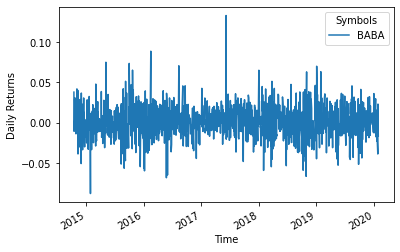

In [38]:
daily_returns.plot();
plt.ylabel('Daily Returns');
plt.xlabel('Time');

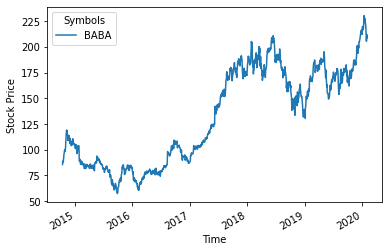

In [39]:
data.plot();
plt.ylabel('Stock Price');
plt.xlabel('Time');

#### Create dataset
lags defines the size of the sliding window 

In [40]:
def create_dataset(stock_symbol, start_date, end_date, lags=5):

  ## downlown stock price data from Yahoo finance
	df = web.DataReader(stock_symbol, "yahoo", start_date, end_date)

  ## create a new dataframe
	## we want to use additional features: lagged returns...today's returns, yesterday's returns, 
	## and the day before yesterday ...
	tslag = pd.DataFrame(index=df.index)
	tslag["Today"] = df["Adj Close"]
	tslag["Volume"] = df["Volume"]

  # Create the shifted lag series of prior trading period close values
	for i in range(0, lags):
		tslag["Lag%s" % str(i+1)] = df["Adj Close"].shift(i+1)

  #create the returns DataFrame
	dfret = pd.DataFrame(index=tslag.index)
	dfret["Volume"] = tslag["Volume"]
	dfret["Today"] = tslag["Today"].pct_change()*100.0

  #create the lagged percentage returns columns
	for i in range(0, lags):
		dfret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)].pct_change()*100.0

  # "Direction" column (+1 or -1) indicating an up/down day
	dfret["Direction"] = np.sign(dfret["Today"])
	
	# because of the shifts there are NaN values ... we want to get rid of those NaNs
	dfret.drop(dfret.index[:lags+1], inplace=True)

	return dfret

In [41]:
# stocks = ['BABA']
start_date='10/30/2014'
end_date='01/30/2020'
data = create_dataset("BABA", datetime(2014,10,30), datetime(2020,1,30), lags=10)

In [42]:
data.head()

,Volume,Today,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Direction
Date,,,,,,,,,,,,,
2014-11-14,29849000,0.226404,-2.842640,3.195387,-3.869073,4.006638,2.679930,2.668631,2.451210,4.194496,3.245441,-0.131677,1.0
2014-11-17,22573000,-0.738487,0.226404,-2.842640,3.195387,-3.869073,4.006638,2.679930,2.668631,2.451210,4.194496,3.245441,-1.0
2014-11-18,41098000,-3.010943,-0.738487,0.226404,-2.842640,3.195387,-3.869073,4.006638,2.679930,2.668631,2.451210,4.194496,-1.0
2014-11-19,46841000,-1.795865,-3.010943,-0.738487,0.226404,-2.842640,3.195387,-3.869073,4.006638,2.679930,2.668631,2.451210,-1.0
2014-11-20,36489000,0.918949,-1.795865,-3.010943,-0.738487,0.226404,-2.842640,3.195387,-3.869073,4.006638,2.679930,2.668631,1.0


In [43]:
data.tail()

,Volume,Today,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Direction
Date,,,,,,,,,,,,,
2020-01-24,18143900,-2.455166,-1.457027,0.049492,-2.273226,1.558449,-0.497643,-0.631378,-1.731166,2.971002,0.924341,1.733944,-1.0
2020-01-27,24574700,-3.873684,-2.455166,-1.457027,0.049492,-2.273226,1.558449,-0.497643,-0.631378,-1.731166,2.971002,0.924341,-1.0
2020-01-28,16196700,2.316637,-3.873684,-2.455166,-1.457027,0.049492,-2.273226,1.558449,-0.497643,-0.631378,-1.731166,2.971002,1.0
2020-01-29,12871900,0.851452,2.316637,-3.873684,-2.455166,-1.457027,0.049492,-2.273226,1.558449,-0.497643,-0.631378,-1.731166,1.0
2020-01-30,14376000,-1.622490,0.851452,2.316637,-3.873684,-2.455166,-1.457027,0.049492,-2.273226,1.558449,-0.497643,-0.631378,-1.0


In [44]:
data.shape

(1310, 13)

In [45]:
# Use the prior 10 days of returns as predictor 
# Label: price movement of the stock
X = data[["Lag1","Lag2","Lag3","Lag4","Lag5", "Lag6", "Lag7", "Lag8", "Lag9", "Lag10"]]
y = data["Direction"]

In [46]:
# The test data is split into two parts: Before and after 1st Jan 2005.
start_test = datetime(2019,12,1)

In [47]:
# Create training and test sets
X_train_full = np.array(X[X.index < start_test])
X_test = np.array(X[X.index >= start_test])
y_train_full = y[y.index < start_test]
y_test = y[y.index >= start_test]

In [48]:
y_train_full[y_train_full==-1]=0
y_test[y_test==-1]=0

In [49]:
y_train_full=np.array(y_train_full)

In [50]:
y_test=np.array(y_test)

In [51]:
X_train_full = X_train_full[:,:,np.newaxis]

In [52]:
X_train_full.shape

(1269, 10, 1)

In [53]:
y_train_full=np.array(y_train_full)

#### train and validation data

In [54]:
training_size = 1000
X_train = X_train_full[:training_size]
X_valid = X_train_full[training_size:]
y_train = y_train_full[:training_size]
y_valid = y_train_full[training_size:]

In [55]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1000, 10, 1), (269, 10, 1), (1000,), (269,))

## Construct a LSTM model

In [56]:
import tensorflow as tf
from keras import regularizers

In [57]:
seq_len_LSTM=10
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(20, input_shape=(seq_len_LSTM, 1), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(10, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.LSTM(10, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(5, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 20)            1760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 10)            1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [58]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model.fit(X_train, y_train,
                    validation_data = (X_valid, y_valid), shuffle = False, ## time-series validation should not be shuffled
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 49ms/step - loss: 0.6936 - accuracy: 0.4800 - val_loss: 0.6938 - val_accuracy: 0.4424
Epoch 2/50
32/32 [==============================] - 0s 16ms/step - loss: 0.6930 - accuracy: 0.5110 - val_loss: 0.6935 - val_accuracy: 0.4610
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4572
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6932 - val_accuracy: 0.4498
Epoch 5/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5019
Epoch 6/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6940 - val_accuracy: 0.4610
Epoch 7/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.4870 - val_loss: 0.6947 - val_accuracy: 0.4498
Epoch 8/50
32

In [60]:
X_test = X_test[:,:,np.newaxis]

In [61]:
X_test.shape

(41, 10, 1)

In [62]:
y_test.shape

(41,)

## Prediction accuracy on unseen test data

In [63]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5610
Test accuracy: 0.5609756112098694
